## Offer Distribution Unknown

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lininterp import interp1d
from numba import njit, vectorize, prange

from math import gamma
from scipy.stats import beta


In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

Let's set up some fast jitted functions that implement beta distributions.  In doing so we recall that the beta density is

$$ 
    p(x, a, b) = \frac{\Gamma(a + b)}{\Gamma(a)\Gamma(b)}
        x^{a-1} (1 - x)^{b-1}
        \qquad (0 \leq x \leq 1)
$$


In [4]:
def beta_function_factory(a, b):
    
    @vectorize
    def p(x):
        r = gamma(a + b) / (gamma(a) * gamma(b))
        return r * x**(a-1) * (1 - x)**(b-1)
    
    @njit
    def p_rvs():
        return np.random.beta(a, b)
    
    return p, p_rvs



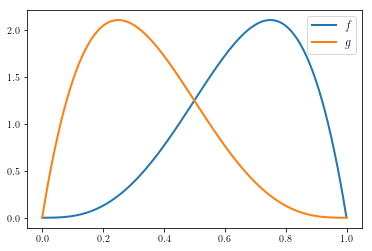

In [6]:
x_grid = np.linspace(0, 1, 100)
f, f_rvs = beta_function_factory(4, 2)
g, g_rvs = beta_function_factory(2, 4)

fig, ax = plt.subplots()

plt.plot(x_grid, f(x_grid), label='$f$', lw=2)
plt.plot(x_grid, g(x_grid), label='$g$', lw=2)

plt.legend(fontsize=12)
plt.show()

A convex combination

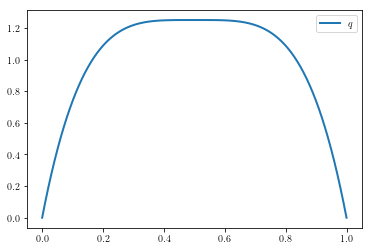

In [7]:

fig, ax = plt.subplots()

plt.plot(x_grid, 0.5 * f(x_grid) + 0.5 * g(x_grid), label='$q$', lw=2)
plt.legend()
plt.show()

In [8]:
class SearchProblem:

    def __init__(self, 
                 β=0.95, 
                 c=0.1, 
                 F_a=4, 
                 F_b=2, 
                 G_a=2, 
                 G_b=4,
                 π_grid_size=20):

        self.β, self.c = β, c
        self.f, self.f_rvs = beta_function_factory(F_a, F_b)
        self.g, self.g_rvs = beta_function_factory(G_a, G_b)
        
        self.π_grid = np.linspace(0, 1, π_grid_size)
        

In [9]:
def Q_factory(sp, mc_size=10000, seed=123):

    # == Simplify names == #
    β, c, π_grid = sp.β, sp.c, sp.π_grid
    f, f_rvs = sp.f, sp.f_rvs
    g, g_rvs = sp.g, sp.g_rvs


    @njit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        new_π =  pf / (pf + pg)
        return new_π
    
    @njit(parallel=False)
    def Q(ψ):
            
        np.random.seed(seed)
        U = np.random.uniform(0, 1, mc_size)

        
        # == Turn ψ into a function == #
        def ψ_f(x):
            return interp1d(π_grid, ψ, x)
        
        new_ψ = np.empty_like(ψ)
        w_prime = np.empty(mc_size)

        for i in prange(len(π_grid)):
            π = π_grid[i]
            
            # Generate draws from q_π
            for m in range(mc_size):
                if U[m] < π:
                    wp = f_rvs()
                else:
                    wp = g_rvs()
                w_prime[m] = wp

            # Evaluate expectation
            integral = 0.0
            for m, wp in enumerate(w_prime):
                integral += max(wp, ψ_f(κ(wp, π)))
            integral = integral / mc_size

            # Update Qψ
            new_ψ[i] = (1 - β) * c + β * integral

        return new_ψ
    
    return Q

In [10]:
def Q_iterator(sp, max_iter=500, tol=1e-4):
    
    ψ_init = np.ones(len(sp.π_grid))
    Q = Q_factory(sp)
    ψ = ψ_init
    ϵ = tol + 1
    i = 0
    
    while i < max_iter and ϵ > tol:
        new_ψ = Q(ψ)
        ϵ = np.max(np.abs(ψ - new_ψ))
        ψ = new_ψ
        i += 1
        
    if i == max_iter:
        print("Warning: hit maximum iterations")
        
        
    return ψ

In [11]:
sp1 = SearchProblem()


In [12]:
ψ_1 = Q_iterator(sp1)


In [13]:
sp2 = SearchProblem(c=0.2)
ψ_2 = Q_iterator(sp2)

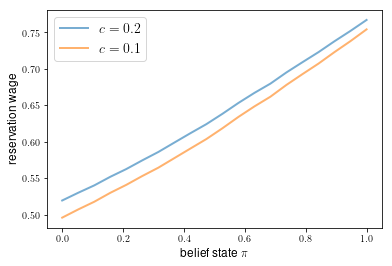

In [14]:
fig, ax = plt.subplots()

ax.plot(sp2.π_grid, ψ_2, lw=2, alpha=0.6, label='$c = 0.2$')
ax.plot(sp1.π_grid, ψ_1, lw=2, alpha=0.6, label='$c = 0.1$')

ax.legend(fontsize=14)
ax.set_xlabel("belief state $\\pi$", fontsize=12)
ax.set_ylabel("reservation wage", fontsize=12)
plt.show()